In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# RNN

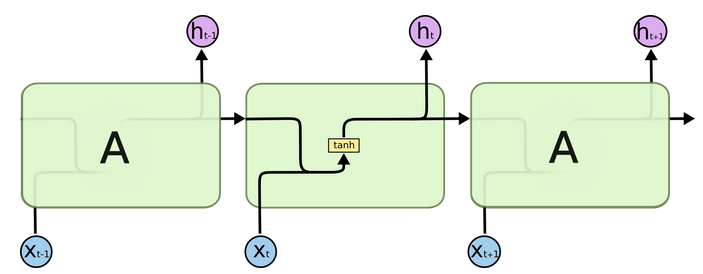 

$$
\begin{align}
h_n &= RNNcell(x_{n-1}, h_{n-1}) \\
    &= Tanh(W[x_{n-1}; h_{n-1}]+b)
\end{align}
$$


In [2]:
rnn = nn.RNN(input_size=128, hidden_size=512,num_layers=1,batch_first=True)

input_embed = torch.randn(4,30,128)

h0 = torch.randn(1, 4, 512)
output, hn = rnn(input_embed, h0)

output.size(), hn.size()

(torch.Size([4, 30, 512]), torch.Size([1, 4, 512]))

# GRU
GRU（Gated Recurrent Unit）也称门控循环单元结构, 它也是传统RNN的变体, 同LSTM一样能够有效捕捉长序列之间的语义关联, 缓解梯度消失或爆炸现象. 同时它的结构和计算要比LSTM更简单, 它的核心结构可以分为两个部分去解析:

更新门 重置门

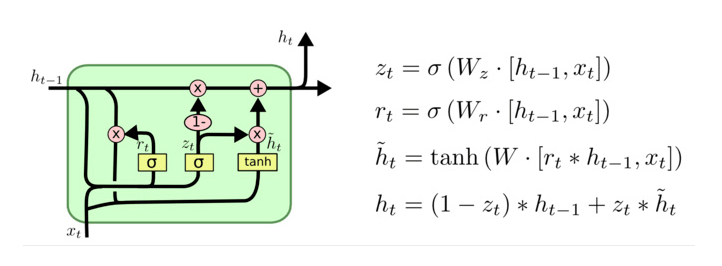 

In [19]:
rnn = nn.GRU(input_size=128, hidden_size=512,num_layers=1,batch_first=True,bidirectional=True)

input_embed = torch.randn(4,30,128)

h0 = torch.randn(2, 4, 512)
output, hn = rnn(input_embed, h0)

print(output.size(), hn.size())
# output[:,-1,:512] == hn
output[:,-1,:].squeeze() == h

torch.Size([4, 30, 1024]) torch.Size([2, 4, 512])


tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

# LSTM

http://colah.github.io/posts/2015-08-Understanding-LSTMs/
https://zhuanlan.zhihu.com/p/42717426

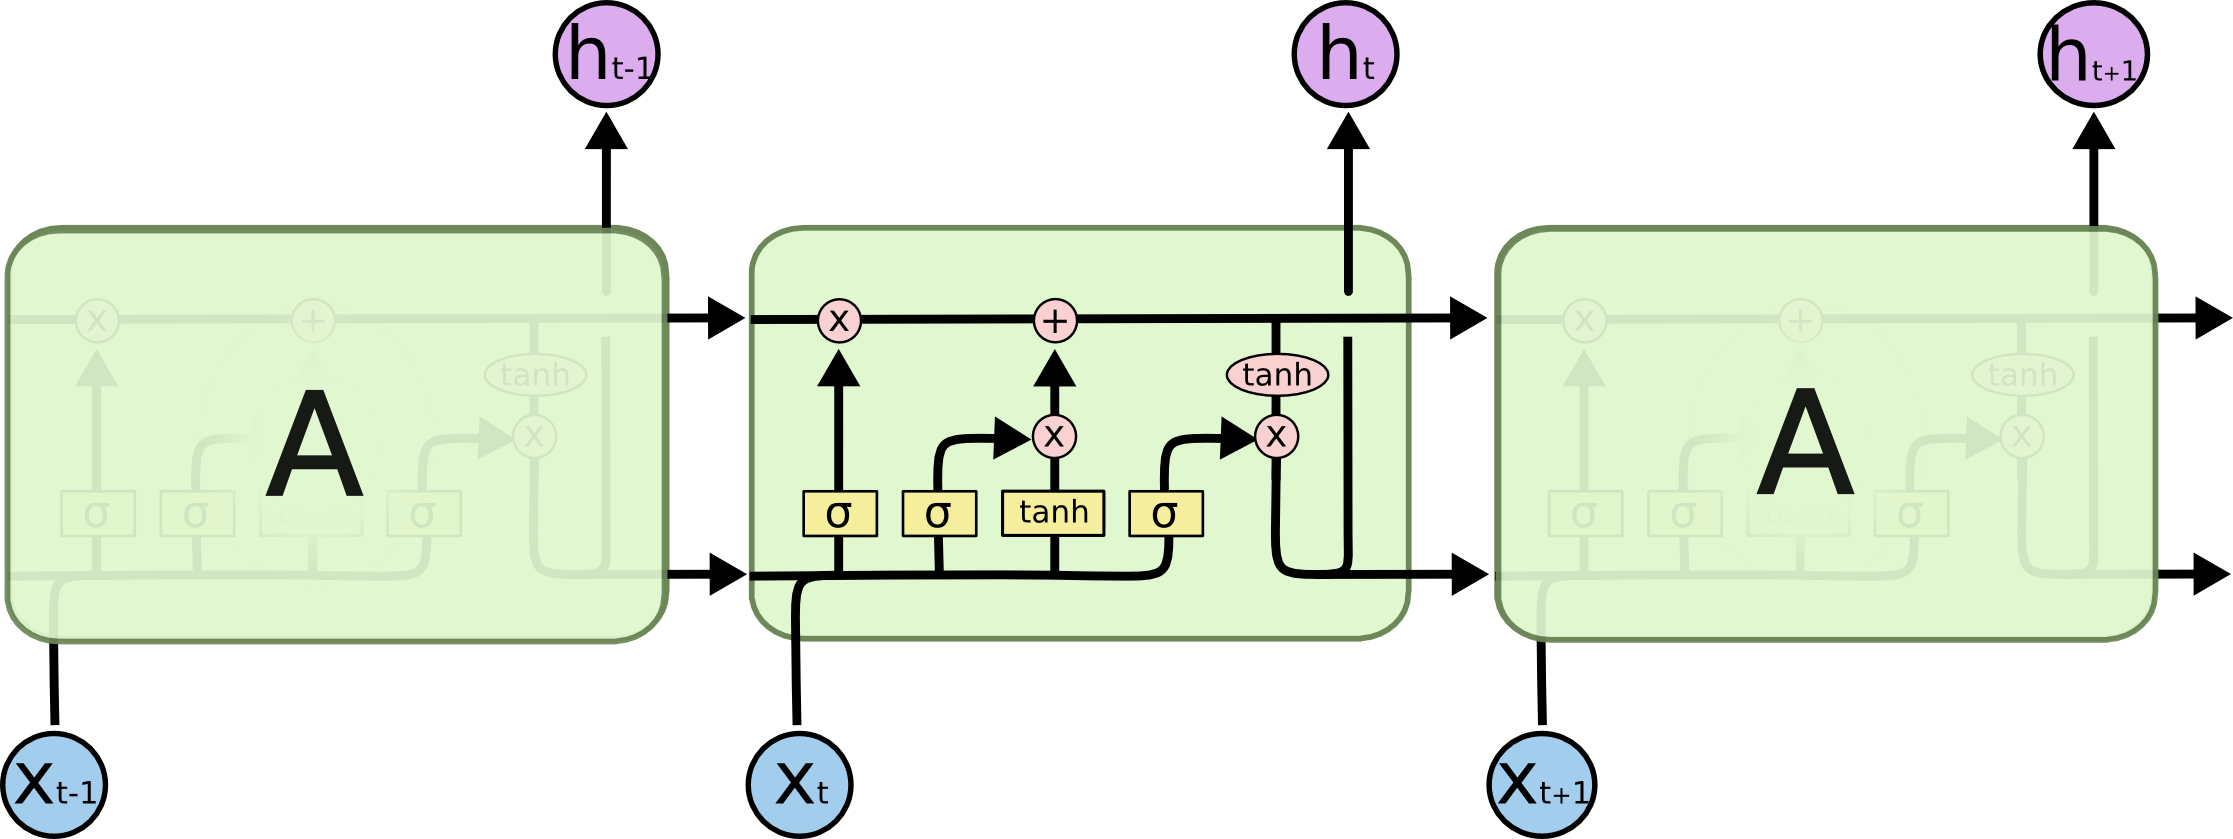 
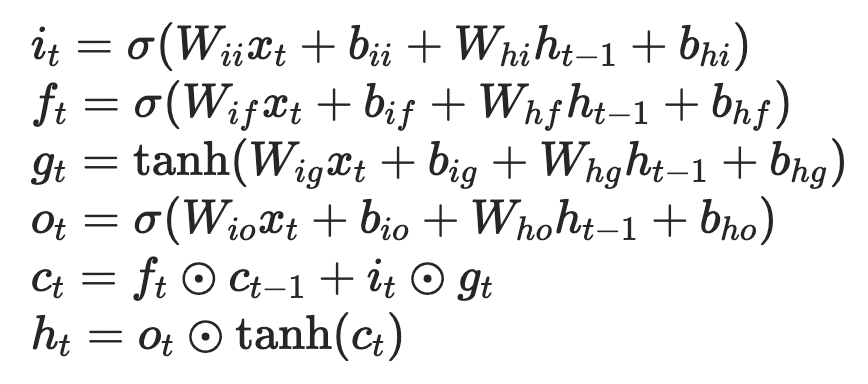

forget input output

In [4]:
rnn = nn.LSTM(input_size=128, hidden_size=512,num_layers=2,batch_first=True)
input_embed = torch.randn(4,30,128)

h0 = torch.randn(2, 4, 512)
c0 = torch.randn(2, 4, 512)
output, (hn,cn) = rnn(input_embed, (h0,c0))

output.size(), hn.size(),cn.size()

(torch.Size([4, 30, 512]), torch.Size([2, 4, 512]), torch.Size([2, 4, 512]))

In [5]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, *args, **kwargs) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cells = nn.ModuleList(nn.LSTMCell(input_size, hidden_size) for _ in range(num_layers))

    def _init_states(self, bsz):
        h0 = torch.zeros(self.num_layers, bsz, self.hidden_size)
        c0 = torch.zeros(self.num_layers, bsz, self.hidden_size)
        return h0, c0

    def forward(self, input_seq, init_states=None):
        """ 
         input_seq: (bsz, seqlen, dim)
        """
        bsz,seqlen,dim = input_seq.size()
        if init_states is None:
            init_states = self._init_states(bsz)

        h0, c0 = init_states

        hidden_states = [] 
        h_i, c_i = h0.squeeze(), c0 .squeeze()
        for i in range(seqlen): 
            x_i = input_seq[:,i,:]                      # (bsz,dim) 每个时间步的输入

            h_i, c_i = self.cells[0](x_i, (h_i, c_i))   # 当前时间步 hidden_state 和 cell_state

            hidden_states.append(h_i)

        output = torch.stack(hidden_states, dim=1)

        return output, (h_i, c_i)

def test_lstm():
    # rnn = nn.LSTM(input_size=128, hidden_size=512,num_layers=1,batch_first=True)
    rnn = MyLSTM(input_size=128, hidden_size=512,num_layers=1,batch_first=True)

    input_embed = torch.randn(4,30,128)

    h0 = torch.randn(1, 4, 512)
    c0 = torch.randn(1, 4, 512)
    output, (hn,cn) = rnn(input_embed,)

    print(output.size(), hn.size(),cn.size())

test_lstm()

torch.Size([4, 30, 512]) torch.Size([4, 512]) torch.Size([4, 512])


In [79]:
from omegaconf import OmegaConf
config_dict = {
    'embed_type' : 'rand', # bert
    'embed_dim' : 768,
    'hidden_size' : 256,
    'dropout' : 0.1,
    'vocab_size' : 1000,
    'tgt_vocab_size': 1000,
    'teacher_forcing_ratio': 0.5
}
config = OmegaConf.create(config_dict)

# Seq2seq Framework

In [71]:
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.embedding = self._load_embed(config)
        
        self.rnn = nn.LSTM(input_size=config.embed_dim, hidden_size=config.hidden_size, bidirectional=True, batch_first=True)
        
        self.fc = nn.Linear(config.hidden_size * 2, config.hidden_size)
        
        self.dropout = nn.Dropout(config.dropout)

    def _load_embed(self, config):
        if config.embed_type != 'bert':
            return nn.Embedding(num_embeddings=config.vocab_size, embedding_dim=config.embed_dim, padding_idx=0)
        else:
            embed_layer = nn.Embedding(num_embeddings=config.vocab_size, embedding_dim=config.embed_dim, padding_idx=0, _weight=None)
            return 
        
    def forward(self, batch):
        
        embedded = self.dropout(self.embedding(batch.input_ids))
        outputs, (hn,cn) = self.rnn(embedded)
        
        print(outputs.size(), hn.size(), cn.size())
        # outputs (bsz, seqlen, dim*n_layer*n_directions)
        # hn = (bsz, dim*n_layer*n_directions)

        #  正向最后一个hidden和反向第一个hidden 拼接，映射还原纬度
        hidden = torch.tanh(self.fc(hn.permute(1,0,2).reshape(outputs.size(0),-1)))
    
        # （bsz,seqlen,dim*2) (bsz,dim)
        return outputs, hidden

encoder = Encoder(config)

In [72]:
from dataclasses import dataclass 

@dataclass
class Batch:
    input_ids : torch.Tensor 
    labels : torch.Tensor
    attention_mask : torch.Tensor = None     
    
    
batch = Batch(torch.randint(0,1000,(4,30)), torch.randint(0,1000,(4,20)))

In [73]:
outputs, hidden = encoder(batch)
outputs.size(), hidden.size()

torch.Size([4, 30, 512]) torch.Size([2, 4, 256]) torch.Size([2, 4, 256])


(torch.Size([4, 30, 512]), torch.Size([4, 256]))

In [74]:
class Attention(nn.Module):
    """
        [decoder_hidden ; encoder_output] -->  (bsz, seqlen)
    """
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        """ (bsz,1,dim) (bsz,seqlen,dim)  """
        
        bsz, seqlen, dim = encoder_outputs.size()
        hidden = hidden.view(bsz,1,-1)
        #repeat decoder hidden state src_len times
        hidden = hidden.repeat(1, seqlen, 1)
        
        #  (bsz, seqlen, dec_dim)             
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        #  (bsz,seqlen,1)
        attention = self.v(energy).squeeze(2)

        return F.softmax(attention, dim=1)
    
att = Attention(256,256)
att(hidden, outputs)

tensor([[0.0311, 0.0329, 0.0299, 0.0324, 0.0322, 0.0340, 0.0344, 0.0316, 0.0317,
         0.0343, 0.0335, 0.0340, 0.0334, 0.0360, 0.0352, 0.0342, 0.0325, 0.0332,
         0.0349, 0.0335, 0.0347, 0.0331, 0.0313, 0.0318, 0.0342, 0.0348, 0.0348,
         0.0336, 0.0320, 0.0345],
        [0.0346, 0.0322, 0.0340, 0.0330, 0.0338, 0.0329, 0.0335, 0.0323, 0.0307,
         0.0340, 0.0345, 0.0346, 0.0336, 0.0334, 0.0339, 0.0339, 0.0328, 0.0325,
         0.0361, 0.0336, 0.0322, 0.0334, 0.0319, 0.0366, 0.0351, 0.0324, 0.0315,
         0.0342, 0.0323, 0.0305],
        [0.0320, 0.0322, 0.0324, 0.0324, 0.0324, 0.0322, 0.0324, 0.0335, 0.0348,
         0.0336, 0.0327, 0.0320, 0.0357, 0.0368, 0.0357, 0.0330, 0.0336, 0.0316,
         0.0342, 0.0342, 0.0317, 0.0342, 0.0329, 0.0322, 0.0351, 0.0345, 0.0336,
         0.0345, 0.0316, 0.0323],
        [0.0316, 0.0324, 0.0343, 0.0359, 0.0318, 0.0340, 0.0312, 0.0311, 0.0328,
         0.0342, 0.0342, 0.0363, 0.0322, 0.0338, 0.0336, 0.0363, 0.0323, 0.0322,
       

In [76]:
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config 

        self.embedding = nn.Embedding(num_embeddings=config.vocab_size, embedding_dim=config.embed_dim, padding_idx=0)
        self.proj_linear = nn.Linear(config.embed_dim, config.hidden_size)
        self.att = Attention(config.hidden_size, config.hidden_size)
        
        self.rnn = nn.GRU(config.hidden_size*3, hidden_size=config.hidden_size, bidirectional=False, batch_first=True)
        
        self.lm_linear = nn.Linear(config.hidden_size*4, config.tgt_vocab_size)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, decoder_input_ids, hidden, encoder_outputs):
        """
            将输入decoder_input_id编码， 计算src上的注意力分数，重新加权

        """
        bsz,srclen,dim = encoder_outputs.size()
        embeded = self.proj_linear(self.embedding(decoder_input_ids)).view(bsz, -1, self.config.hidden_size)                    # (bsz, dim)
        attention_socre_over_src = self.att(hidden, encoder_outputs)  # (bsz,srclen)
        
        # print(embeded.size(), attention_socre_over_src.size(), encoder_outputs.size())

        weighted_src =  attention_socre_over_src.unsqueeze(1) @ encoder_outputs   # (bsz,srclen,dim*2) (bsz,1,srclen)
        
        # （bsz,1,dim*2) (bsz,1,dim)
        rnn_input = torch.cat([weighted_src, embeded], dim=-1)
        
        #  加权的src和当前decoder_input_id的表示拼接，输入rnn走一个时间步
        output, hidden = self.rnn(rnn_input, hidden.view(-1,bsz, self.config.hidden_size))

        assert (output == hidden.permute(1,0,2)).all()    # (bsz,1,dim)
        
        #  (bsz,1,dim)  (bsz,1,dim*2) (bsz,1,dim)  映射至词表大小
        logits = self.lm_linear(torch.cat([output, weighted_src, embeded], dim=-1))

        return logits, hidden
    
decoder = Decoder(config)

logits, hidden = decoder(batch.input_ids[:, 0], hidden, outputs)
logits.size(), hidden.size()

(torch.Size([4, 1, 1000]), torch.Size([1, 4, 256]))

In [80]:
import random
class Seq2seqModel(nn.Module):
    def __init__(self, config, encoder, decoder) -> None:
        super().__init__()
        self.config = config 

        self.encoder = encoder 
        self.decoder = decoder 

    def forward(self, batch):
        bsz,srclen = batch.input_ids.size()
        tgtlen = batch.labels.size(1)

        decoder_outputs = torch.zeros(bsz, tgtlen, self.config.tgt_vocab_size)

        encoder_output, hidden = self.encoder(batch)    # 获取encoder的输出: 输入序列的编码向量
        decoder_input_id = batch.labels[:, 0]           # 目标序列，这里先取第一个 <S>
        for i in range(1, tgtlen):
            output, hidden = self.decoder(decoder_input_id, hidden, encoder_output)
            decoder_outputs[:,i] = output.squeeze()

            teacher_forcing = random.random() < self.config.teacher_forcing_ratio
            pred_id = output.argmax(-1)

            decoder_input_id = pred_id if teacher_forcing else batch.labels[:, i]

        return decoder_outputs   # (bsz,tgtlen, vocab_size)

    def inference(self, batch):

        return
    
seq2seq = Seq2seqModel(config, encoder, decoder)
decoder_outputs = seq2seq(batch)
decoder_outputs.size()

torch.Size([4, 30, 512]) torch.Size([2, 4, 256]) torch.Size([2, 4, 256])


torch.Size([4, 20, 1000])

In [20]:
labels = torch.randint(0,100,(4,20))
labels

tensor([[64, 71, 20, 22, 79, 81, 60, 42, 33, 68, 20, 15, 68, 99, 91, 16,  9, 55,
          8, 94],
        [78, 99, 68, 40, 17, 23, 39, 90, 75, 35, 30, 61, 33, 57, 25, 20, 14, 86,
         79, 90],
        [22, 14,  3, 81, 31, 71, 81, 36, 71, 86, 57,  7, 15,  2, 46, 64, 17,  4,
         67, 39],
        [52, 79, 54, 91, 46, 64, 78, 34, 95,  7, 57, 90, 95, 63, 68, 16, 12, 19,
         80, 62]])

In [24]:
logits = torch.randn(4,20,100)

                        #  (4,20,100)    (4, 20)
nn.CrossEntropyLoss()(logits.view(-1, 100), labels.view(-1))

tensor(5.1179)

In [22]:
nn.CrossEntropyLoss()(torch.randn(4,10), torch.tensor([1,2,4,5]).view(-1))

tensor(2.6499)

In [90]:
from collections import namedtuple
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("/pretrains/pt/bert-base-uncased")
sentence = ["You know nothing.",  "Chaos is a ladder."]
td = tokenizer(sentence, return_tensors='pt',padding=True, truncation=True)
Batch = namedtuple("Batch", ["input_ids","attention_mask","token_type_ids","labels"])
batch = Batch(**td, labels=td.input_ids)
td 

{'input_ids': tensor([[  101,  2017,  2113,  2498,  1012,   102,     0],
        [  101,  8488,  2003,  1037, 10535,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1]])}

In [91]:
Batch = namedtuple("Batch", ["input_ids","attention_mask","token_type_ids","labels"])
batch = Batch(**td, labels=td.input_ids)

https://github.com/domschl/torch-poet/blob/master/torch_poet.ipynb

https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb